# Exercise 1
Berkay Günes, Buhar Bacho, Sophia Klubertz

## 1 Exploring the Data

<div style="color: green; font-weight: bold">Test</div>

In [2]:
from sklearn.datasets import load_digits
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

In [3]:
digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

Text(0.5, 1.0, "Interpolation methode 'nearest'")

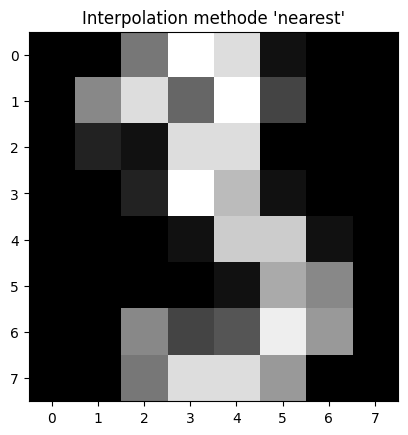

In [4]:
img = images[3]
assert 2 == len(img.shape)
plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest")
plt.title("Interpolation methode 'nearest'")

Text(0.5, 1.0, "Interpolation methode 'bicubic'")

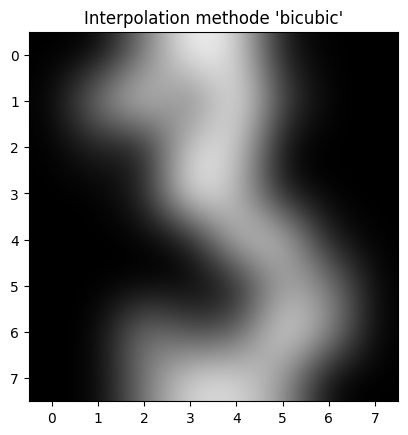

In [5]:
plt.imshow(img, interpolation="bicubic")
plt.title("Interpolation methode 'bicubic'")

In [6]:
mask = np.logical_or(target == 3,target == 9)

X_all = data[mask]
y_all = target[mask]

X_train , X_test , y_train , y_test =\
    model_selection.train_test_split(X_all, y_all, test_size = 0.4, random_state = 0)

<div style="color: green; font-weight: bold">This part of the solution is in the main parts identically to th sample solution, although we didn't plot the interpolation method 'bilinear'. <br>
Also we didnt rename the labels from 3 and 9 to -1 and 1, which is the case for the rest of the exercise too.</div>

## 2 Hand-crafted classifier
### 2.1 Feature construction
To determine the important pixels for a classification we first look at the difference between the average 3's and 9's. 

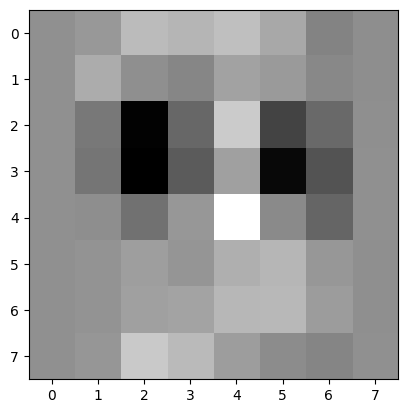

In [7]:
av3 = sum(images[target == 3]) / len(images[target == 3])
av9 = sum(images[target == 9]) / len(images[target == 9])

diff39 = (av3-av9)
plt.imshow(diff39, interpolation='nearest')

This image shows us in which pixels the difference is biggest between the 3's and 9's. <br>
The four pixels to focus on are (2,2), (2,3), (4,4) and (5,3), but not all four pixels are equaly important. 

In [8]:
def features2d(x):
    pc = np.zeros((len(x), 2))
    
    for i in range(0, len(x)):
        pc[i, 0] = 8.8 * x[i, 8*2+2] + 9 * x[i, 8*3+2] + 8.5 * x[i, 8*3+5] + 4.8 * x[i, 8*2+5]
        pc[i, 1] = 7 * x[i, 8*4+4] + 3.7 * x[i, 8*2+4] + 3.6 * x[i, 8*7+2]
        
    return pc

In [9]:
features = features2d(X_all)

<div style="color: green; font-weight: bold">To find the best features, we used a different method than the sample solution.
We looked at where the means of the two classes differed the most and choose 7 pixels in total to focus on specifically. This gave good results for the feature space and seems to give better results than the method used in the sample solution.</div>

### 2.2 Scatterplot

Text(0, 0.5, 'PC2')

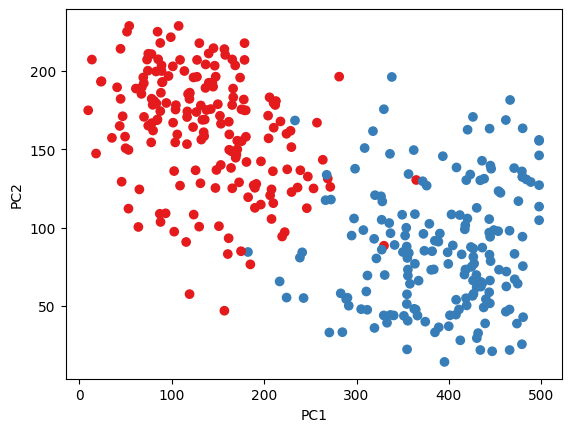

In [10]:
colors = ['#e41a1c', '#377eb8']
labels = np.empty(len(y_all), dtype = int)
labels[y_all == 9] = 1
labels[y_all == 3] = 0

plt.scatter(features.T[0], features.T[1], color=np.array(colors)[labels])
plt.xlabel("PC1")
plt.ylabel("PC2")

<div style="color: green; font-weight: bold">Unfortunatly we forgot to print out the legend. The red dots represent the 3's and the blue dots the 9's. </div>

### 2.3 Decision rule

In [11]:
training_features = features2d(X_train)
test_features = features2d(X_test)
training_labels = y_train

In [12]:
def nearest_mean(training_features, training_labels, test_features):
    
    mean_3 = sum(training_features[training_labels == 3]) / len(training_features[training_labels == 3])
    mean_9 = sum(training_features[training_labels == 9]) / len(training_features[training_labels == 9])
    
    dis_3 = np.linalg.norm(mean_3 - test_features, axis = 1)
    dis_9 = np.linalg.norm(mean_9 - test_features, axis = 1)
    
    d = dis_3 - dis_9
    
    label = np.empty(len(d), dtype = int)
    
    label[d < 0] = 3
    label[d > 0] = 9
    
    return label, mean_3, mean_9

In [13]:
predicted_labels, mean_3, mean_9 = nearest_mean(training_features, y_train, test_features)

In [14]:
error = abs(100*(sum(y_test == predicted_labels)-len(y_test))/len(y_test))
print("The classifier misclassified %f %% of the data" % round(error,2))

The classifier misclassified 2.740000 % of the data


<div style="color: green; font-weight: bold">The code does the same as the sample solution. A loop over the labels would make the code more elegant though and in a case with more classes also easier to write. The labels in the end are again 3 and 9 and not -1 and 1.
We also didn't calculate the error of the training data.</div>

### 2.4 Visualize the decision regions

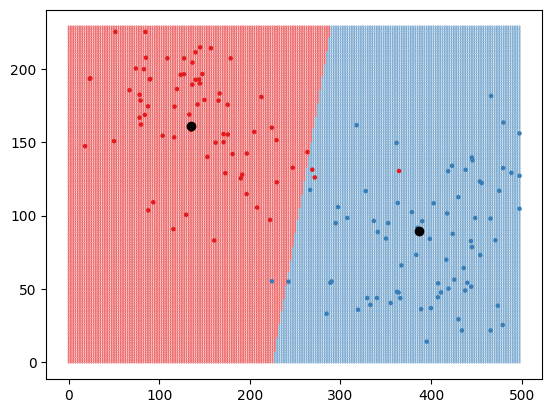

In [17]:
fig, ax = plt.subplots()

y = np.linspace(0,max(features.T[1]),200)
for i in range(0, len(y)):
    grid = np.array([np.linspace(0,max(features.T[0]),200), np.ones(200)*y[i]])
    grid_labels, mean_3, mean_9 = nearest_mean(training_features, training_labels, grid.T)
    grid_labels[grid_labels == 9] = 1
    grid_labels[grid_labels == 3] = 0
    ax.scatter(grid[0], grid[1], color = np.array(colors)[grid_labels], s = 0.1)

predicted_labels_c = y_test
predicted_labels_c[predicted_labels_c == 9] = 1
predicted_labels_c[predicted_labels_c == 3] = 0
    
ax.scatter(test_features.T[0], test_features.T[1], color=np.array(colors)[y_test], s = 5)
ax.scatter(mean_3[0], mean_3[1], c = 'black')
ax.scatter(mean_9[0], mean_9[1], c = 'black')

<div style="color: green; font-weight: bold">Works good. The plotting of the grid is not the best solution. We loop over every line, which makes it really slow for finer grids. That would work better with the meshgrid function, so the coordinate system can be given in the nearest_mean function, which was the problem we couldn't figure out to do it all at once and not over a loop.  <br>
We didn't use use the method to determine the decision boundary with $\beta$ and $b$ since it wasn't clear to us to do so in the task and our decision boundary seemed to be quite good.</div>

## 3 LDA
### 3.1 Implement LDA training

In [18]:
def fit_lda(tf, tl):
    D = np.shape(tf)[1]
    mu = np.zeros((2,D))
    
    for i in range(0,D):
        mu[0, i] = np.mean(tf[tl==3].T[i])
        mu[1, i] = np.mean(tf[tl==9].T[i])
    
    covmat = 1/len(tf) * (len(tf[tl==3]) * np.cov(tf[tl==3].T) + len(tf[tl==9]) * np.cov(tf[tl==9].T))
    
    p = np.zeros((2,1))
    p[0] = len(tf[tl==3])/len(tf)
    p[1] = len(tf[tl==9])/len(tf)
    
    return mu, covmat, p
    
mu, covmat, p = fit_lda(training_features, training_labels)

<div style="color: green; font-weight: bold">Same</div>

### 3.2 Implement LDA prediction

In [23]:
def predict_lda(mu, covmat, p, testf):
    
    beta = np.linalg.inv(covmat) @ ( mu[0].T - mu[1].T )
    b = 0.5 * (mu[1] @ np.linalg.inv(covmat) @ mu[1].T - mu[0] @ np.linalg.inv(covmat) @ mu[0].T)
    
    y = np.sign(testf @ beta + b)
    
    y[y==-1] = 3
    y[y== 1] = 9
    
    #print(b)
    #print(beta)
    
    return y.astype(int)

predicted_labels = predict_lda(mu, covmat, p, test_features)

<div style="color: green; font-weight: bold">Used different equation for $b$ which was given in the lecture and the equation on the sheet came a bit late in the updated version. <br>
We didn't calculate the error of the classifier. This would essantialy be the same though as we already did in the task 2.
While debugging we put the print in to see what we calculate. In the following part it will print it quite often though, so it is recommened to comment it out, which we forgot to do before handing it in. :)</div>

### 3.3 Visualization
Plotting of the training features and the gaussian.

Text(0.5, 1.0, 'Training data')

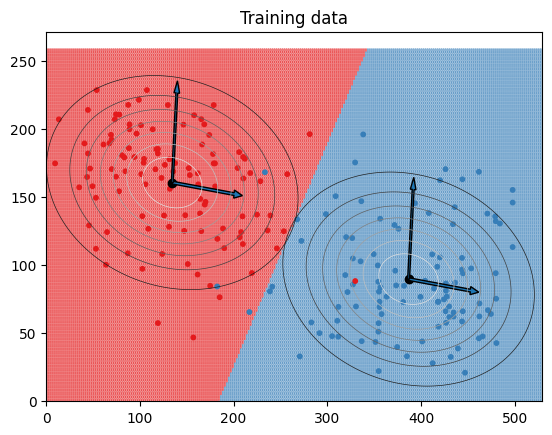

In [24]:
fig, ax = plt.subplots()

y = np.linspace(0,max(features.T[1])+30,250)
for i in range(0, len(y)):
    grid = np.array([np.linspace(0,max(features.T[0])+30,250), np.ones(250)*y[i]])
    grid_labels = predict_lda(mu, covmat, p, grid.T)
    grid_labels[grid_labels == 9] = 0
    grid_labels[grid_labels == 3] = 1
    ax.scatter(grid[0], grid[1], color = np.array(colors)[grid_labels], s = 0.1)
    
predicted_labels_c = y_train
predicted_labels_c[predicted_labels_c == 9] = 1
predicted_labels_c[predicted_labels_c == 3] = 0

x,y = np.mgrid[0:530:1,0:250:1]
data = np.dstack((x,y))
z_1 = multivariate_normal(mu[0], covmat).pdf(data)
ax.contour(x,y,z_1,linewidths=0.5)
z_2 = multivariate_normal(mu[1], covmat).pdf(data)
ax.contour(x,y,z_2,linewidths=0.5)
    
#ax.scatter(test_features.T[0], test_features.T[1], color=np.array(colors)[y_test], s = 10)
ax.scatter(training_features.T[0], training_features.T[1], color=np.array(colors)[predicted_labels_c], s = 10)
ax.scatter(mu[0,0], mu[0,1], c = 'black')
ax.scatter(mu[1,0], mu[1,1], c = 'black')

eig_val, eig_vec = np.linalg.eig(covmat)

ax.arrow(mu[1,0], mu[1,1], np.sqrt(eig_val[0])*eig_vec[:,0][0], np.sqrt(eig_val[0])*eig_vec[:,0][1], width = 2)
ax.arrow(mu[1,0], mu[1,1], np.sqrt(eig_val[1])*eig_vec[:,1][0], np.sqrt(eig_val[0])*eig_vec[:,1][1], width = 2)

ax.arrow(mu[0,0], mu[0,1], np.sqrt(eig_val[0])*eig_vec[:,0][0], np.sqrt(eig_val[0])*eig_vec[:,0][1], width = 2)
ax.arrow(mu[0,0], mu[0,1], np.sqrt(eig_val[1])*eig_vec[:,1][0], np.sqrt(eig_val[0])*eig_vec[:,1][1], width = 2)
plt.title("Training data")

Text(0.5, 1.0, 'Testing data')

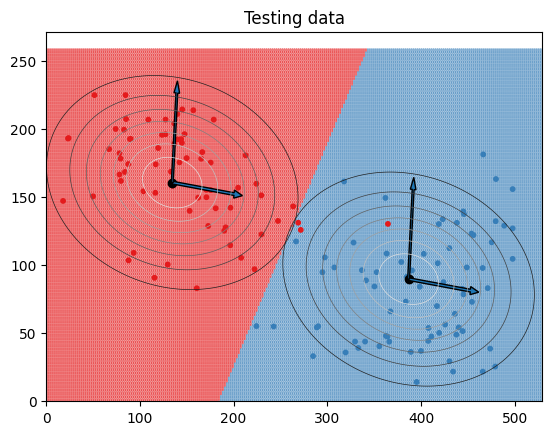

In [25]:
fig, ax = plt.subplots()

y = np.linspace(0,max(features.T[1])+30,250)
for i in range(0, len(y)):
    grid = np.array([np.linspace(0,max(features.T[0])+30,250), np.ones(250)*y[i]])
    grid_labels = predict_lda(mu, covmat, p, grid.T)
    grid_labels[grid_labels == 9] = 0
    grid_labels[grid_labels == 3] = 1
    ax.scatter(grid[0], grid[1], color = np.array(colors)[grid_labels], s = 0.1)
    
predicted_labels_c = y_train
predicted_labels_c[predicted_labels_c == 9] = 1
predicted_labels_c[predicted_labels_c == 3] = 0

x,y = np.mgrid[0:530:1,0:250:1]
data = np.dstack((x,y))
z_1 = multivariate_normal(mu[0], covmat).pdf(data)
ax.contour(x,y,z_1,linewidths=0.5)
z_2 = multivariate_normal(mu[1], covmat).pdf(data)
ax.contour(x,y,z_2,linewidths=0.5)
    
ax.scatter(test_features.T[0], test_features.T[1], color=np.array(colors)[y_test], s = 10)
#ax.scatter(training_features.T[0], training_features.T[1], color=np.array(colors)[predicted_labels_c], s = 5, marker = "x")
ax.scatter(mu[0,0], mu[0,1], c = 'black')
ax.scatter(mu[1,0], mu[1,1], c = 'black')

eig_val, eig_vec = np.linalg.eig(covmat)

ax.arrow(mu[1,0], mu[1,1], np.sqrt(eig_val[0])*eig_vec[:,0][0], np.sqrt(eig_val[0])*eig_vec[:,0][1], width = 2)
ax.arrow(mu[1,0], mu[1,1], np.sqrt(eig_val[1])*eig_vec[:,1][0], np.sqrt(eig_val[0])*eig_vec[:,1][1], width = 2)

ax.arrow(mu[0,0], mu[0,1], np.sqrt(eig_val[0])*eig_vec[:,0][0], np.sqrt(eig_val[0])*eig_vec[:,0][1], width = 2)
ax.arrow(mu[0,0], mu[0,1], np.sqrt(eig_val[1])*eig_vec[:,1][0], np.sqrt(eig_val[0])*eig_vec[:,1][1], width = 2)

plt.title("Testing data")

<div style="color: green; font-weight: bold">Same, except we used arrows in just two directions and also plotted the gaussian distribution over our mean point and also plotted the testing data.</div>

### 3.4 Quantitative performance evaluation

In [26]:
def lda_cv(x,y):
    kf = KFold(n_splits = 10, shuffle = True)
    error = []
    
    for train_lda, test_lda in kf.split(x):
        x_train, y_train = x[train_lda], y[train_lda]
        x_test, y_test   = x[test_lda] , y[test_lda]
        mu, covmat, p = fit_lda(features2d(x_train), y_train)
        labels = predict_lda(mu, covmat, p, features2d(x_test))
        fp = 0
        fn = 0
        for i in range(len(y_test)):
            if (labels[i] == 3) and (y_test[i] != 3):
                fp = fp + 1
            if (labels[i] != 3) and (y_test[i] == 3):
                fn = fn + 1
            if (labels[i] == 9) and (y_test[i] != 9):
                fp = fp + 1
            if (labels[i] != 9) and (y_test[i] == 9):
                fn = fn + 1
        error.append((fp+fn)/len(labels))
    
    return error

error = lda_cv(X_all, y_all)

In [27]:
clf = LinearDiscriminantAnalysis()
scores = cross_val_score(clf, X_all, y_all, cv = 10)

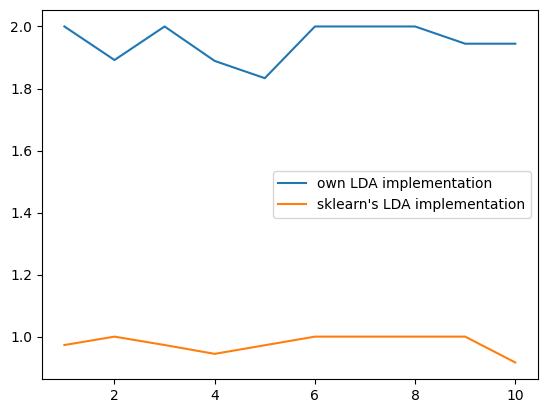

In [28]:
fig, ax = plt.subplots()

ax.plot(np.linspace(1,10,10), error, label = "own LDA implementation")
ax.plot(np.linspace(1,10,10), scores, label = "sklearn's LDA implementation")
ax.legend()

Our own classifier seems to work quite consistantly with just a small variation. The build in classifier from sklearn is still quite a lot more accurate in predicting the labels though.

<div style="color: green; font-weight: bold">We approached this task a bit differently as the sample solution. We calculated the error from our classifier and compared it to what LDA classifier from sklearn would get. <br>
For what was asked in the task we should have looked at the mean and standard variation of our error from the cross validation.</div>

## 4 SVM

In [93]:
#due to the minimization of the loss-function the SVM-alogorithm will find opatimal parameters for the seperation of the classes
class SVM:
    
    #define instances
    #learning_rate (Tau) determines the stepsize of the system, C balances the maximization of the margin and right classification
    #max_iter is the number of iteration, system should convergete but not be to slow
    
    def __init__(self, Tau=0.01, lambd=0.1, max_iter=1000):
        self.Tau= Tau
        self.lambd=lambd
        self.max_iter=max_iter
        self.beta= None #initialize w and b
        self.b= None
        
    #find optimal parameters beta and b 
    #calculate fit-parameters, i.e. mean and covariance-matrix
    def fit(self, X, y):        
        self.beta= np.random.normal(0,1,len(X.T)) #length = number of features (not reduced)
        self.b= 0
        
        y[y == 3] = -1 #rename
        y[y == 9] = 1
        
        i=0
        while i < self.max_iter:
            #initialize predicted labels
            y_pred = np.dot(X , self.beta) + self.b

            #Formula of the gradients (see sheet)
            gradient_beta = self.beta + self.lambd/len(X) * np.dot(np.where(y*y_pred < 1, -y, 0), X) #len(X)=number of the samples
            gradient_b = self.lambd/len(X) * np.sum(np.where(y*y_pred < 1, -y, 0))

            #optimize these parameters (see sheet)
            self.beta = self.beta - self.Tau * gradient_beta
            self.b = self.b - self.Tau * gradient_b
            i +=1
            
    #predicted labels
    def predict(self, X):
        y_pred=np.sign(np.dot(X , self.beta) + self.b)
        y_pred[y_pred==-1] = 3 #rename
        y_pred[y_pred== 1] = 9
        return y_pred.astype(int)

In [94]:
svm=SVM()
svm.fit(training_features, training_labels)
y_pred = svm.predict(test_features)
print(y_pred)

[9 9 9 3 3 9 9 9 9 9 3 3 9 3 9 3 3 9 9 9 3 9 3 3 3 3 3 9 9 3 9 9 9 3 9 9 9
 9 3 3 3 9 3 3 3 3 3 3 3 3 3 9 9 9 9 9 9 3 3 9 9 3 3 3 9 9 3 9 3 9 3 3 3 3
 9 3 3 3 9 3 3 9 9 9 9 3 9 3 9 3 9 3 9 3 9 9 9 9 3 9 3 3 3 3 9 9 3 3 9 9 3
 9 9 9 3 3 3 9 9 9 9 9 3 3 9 3 3 9 3 9 9 9 9 9 9 9 9 9 3 3 9 3 3 3 9 9]


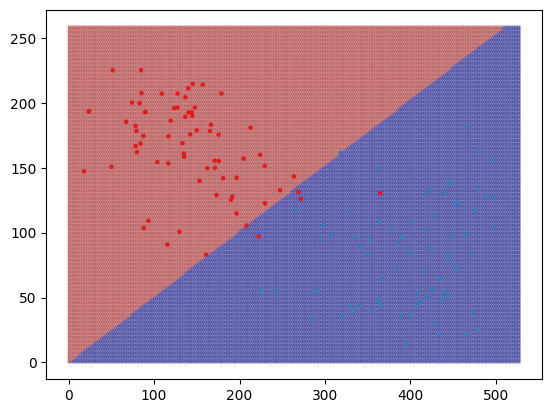

In [103]:
fig, ax = plt.subplots()

y = np.linspace(0,max(features.T[1])+30,250)
for i in range(0, len(y)):
    grid = np.array([np.linspace(0,max(features.T[0])+30,250), np.ones(250)*y[i]])
    grid_labels = svm.predict(grid.T).astype('str')
    grid_labels[grid_labels == "9"] = "#1a1c8a" 
    grid_labels[grid_labels == "3"] = "#a83232"
    ax.scatter(grid[0], grid[1], c = grid_labels, s = 0.1)
    
predicted_labels_c = y_test
predicted_labels_c[predicted_labels_c == 9] = 1
predicted_labels_c[predicted_labels_c == 3] = 0
    
ax.scatter(test_features.T[0], test_features.T[1], color=np.array(colors)[y_test], s = 5)

<div style="color: green; font-weight: bold">For this part we tried to implement the SVM prediction as a class, but the code still works the same and gives the same results. <br>
In the end we were running out of time and therefore weren't able to choose better visiable colours for the plot and also to finish the sheet with the Loss functions.</div>